In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
from IPython import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import sys
sys.path.append('..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks_v2 import OrderbookEpisodesGenerator
from helper.Q_learning import QLearn, round_custombase

/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


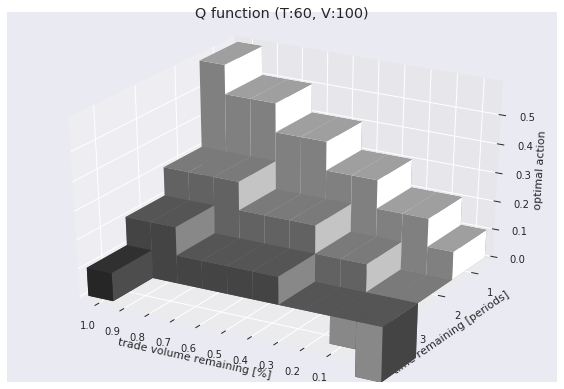

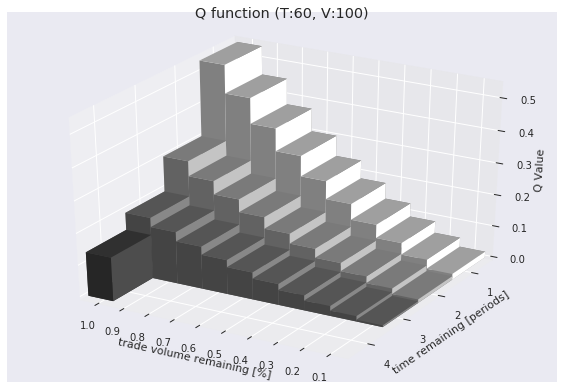

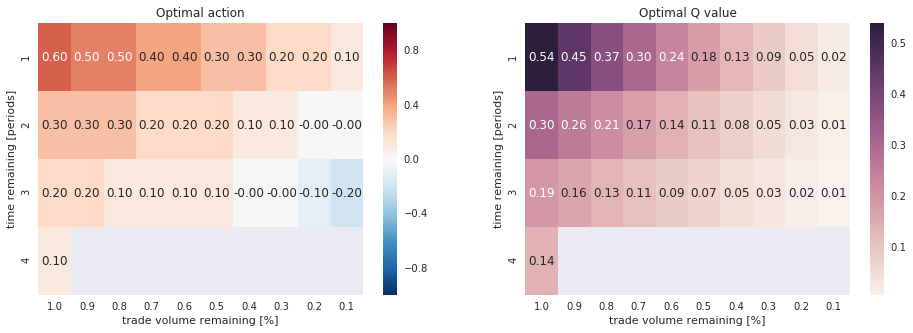

In [2]:
name = '1611-1701_USDTBTC_Qtable_100vol10_60T4'

modelpath = os.path.join("../Runs/evaluation/models/{}.json".format(name))
ql = QLearn.load(infile=modelpath)
ql.plot_Q(z_represents="action")
ql.plot_Q(z_represents="Q")
ql.heatmap_Q()

In [3]:
ql = QLearn.load(infile=modelpath)

T = ql.T
V = ql.V
period_length = ql.period_length
actions = ql.actions

filename_train = '/home/axel/data/obs_2016-12_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2017-02_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*period_length)
print("Length of episodes_train: {}".format(len(episodes_train)))

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*period_length)
print("Length of episodes_test: {}".format(len(episodes_test)))

Length of episodes_train: 743
Length of episodes_test: 670


In [4]:
def plot_experiment_results(experiments, name=None, ylim=None, showfliers=False, hline=None):
    assert isinstance(hline, str) or hline is None
    
    experiments.plot.box(showmeans=True, color={'medians':'green'}, figsize=(12, 8), showfliers=showfliers)

    plt.axvline(2.5, color='black')
    plt.axvline(3.5, color='black')
    plt.axhline(0, color='black')
    
    if hline is not None:
        plt.axhline(experiments[hline].mean(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='min mean')
        plt.axhline(experiments[hline].median(), color='green', alpha=0.5, linewidth=2, linestyle='--', label='min median')
    
    title = "{} samples  \n{} - {}".format(len(experiments), experiments.index[0], experiments.index[-1])
    if name is not None:
        title = "{}: {}".format(name, title)
    print(title)
    #plt.suptitle(title)
    plt.xlabel("Strategies")
    plt.ylabel("Occured costs")
    plt.savefig("boxplot_train.pdf")
    plt.xticks(rotation=70)
    if ylim is not None:
        plt.ylim(ylim)    
    plt.legend(loc='best')
    
    plt.show()

In [5]:
def run_Q(V, H, T, ql, episode_windows, actions, costs=None):
    costs = pd.DataFrame([])
    period_length = int(H/T)

    for e, episode in tqdm(enumerate(episode_windows)):
        index = episode[0].timestamp
        
        volume = V
        
        ## Learned strategy
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                         period_length=period_length)
        for tt in range(1, T+1, 1)[::-1]:
            new_vol = round_custombase(ots.volume, base=ql.vol_intervals)  
        
            if new_vol > 0:
                idx = (T-tt)*period_length
                state = ql.state_as_string(time_left=tt, volume_left=new_vol/V)
                # print(idx, state)
                action = ql.chooseAction(state)
        
                # print(state, action)
                obs = episode[period_length * (T-tt)].copy()
                # obs = [elem.copy() for elem in obs_]
            
                ask = obs.get_ask()
                # center = ots.masterbook.get_center()
                limit = ask * (1. + (action/100.))
            else:
                # theoreticall done
                limit == None
            ots.trade(limit = limit, extrainfo={'ACTION':action})
        costs.loc[index, 'Learned_1611-1701'] = ots.history.cost.sum()

    
        ## market order
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        period_length=period_length)
        ots.trade(limit = None)
        costs.loc[index, 'Market'] = ots.history.cost.sum()
        
        # for a in actions:
        a = 0.4
        lim = episode[0].get_ask() * (1. + (a/100.))
        # print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=1,
                                        period_length=period_length*T)
        ots.trade(limit = lim)
        key = 'ask*{:1.3f}'.format((1. + (a/100.)))
        costs.loc[index, key] = ots.history.cost.sum()

        
        if e%5==0 or e==len(episode_windows)-1:
            display.clear_output(wait=True)
            plot_experiment_results(costs, name='Testset (USDT-BTC, Feb 2017):')
            
            # costs.to_csv("../Runs/evaluation/Evaluation_obs_TESTSET_2016-12_USDT_BTC_LEARNED_.csv")
            mean = costs.mean()
            print(mean)
            print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))
        
    return costs

## Check for best S&L Strategy over training data (Nov16-Jan17)

Trainset (USDT-BTC): 2027 samples  
2016-11-08T10:00 - 2017-01-31T22:48


/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


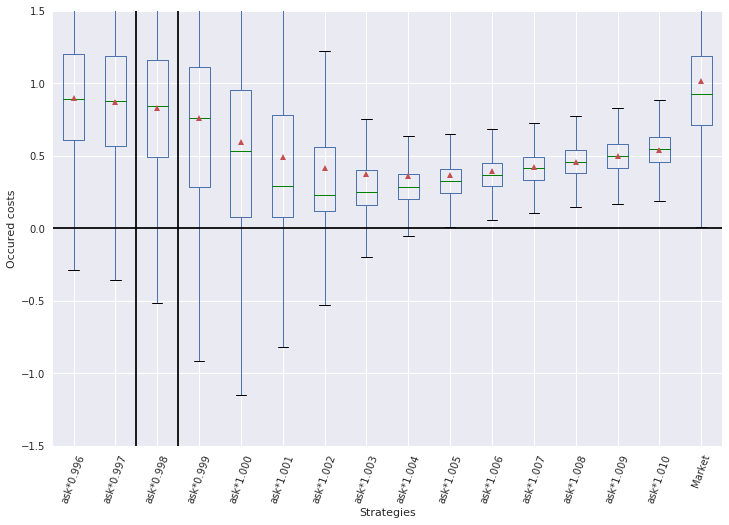

Minimal costs reached by S&L strategy: 'ask*1.004': 0.3604


In [6]:
costs_list_train = pd.concat([
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-11_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-12_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2017-01_USDT_BTC.csv", index_col=0)])

plot_experiment_results(costs_list_train, name='Trainset (USDT-BTC)', ylim=(-1.5, 1.5))

mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))

### Compare strategies on Testset (Feb2017)

Testset (USDT-BTC, Feb 2017):: 5 samples  
2017-02-01T00:00 - 2017-02-01T04:00


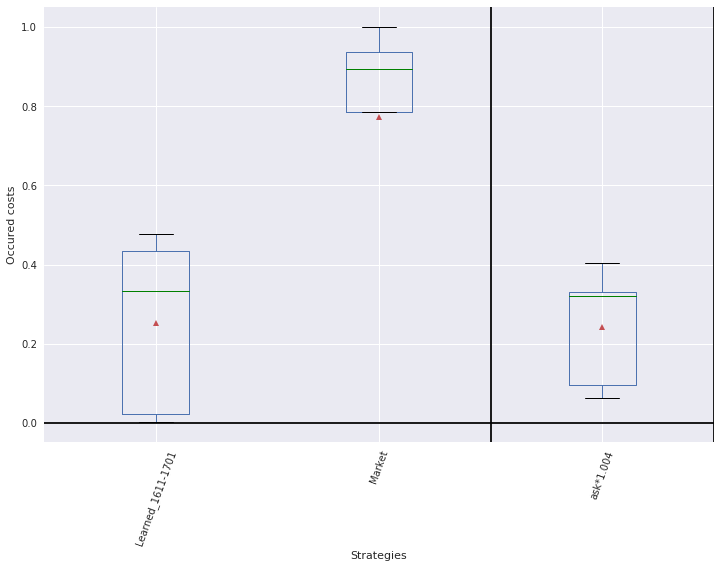

5it [00:59, 11.86s/it]

Learned_1611-1701    0.253678
Market               0.771657
ask*1.004            0.242898
dtype: float64
Minimal costs reached by S&L strategy: 'ask*1.004': 0.2429


In [7]:
T = ql.T
V = ql.V
period_length = ql.period_length
print("V={}, T={}, period_length={}".format(V, T, period_length))

costs_list = run_Q(V=100, H=T*period_length, T=T, ql=ql,
                   episode_windows=episodes_test[:5], actions=actions)

Trainset (USDT-BTC): 5 samples  
2017-02-01T00:00 - 2017-02-01T04:00


/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


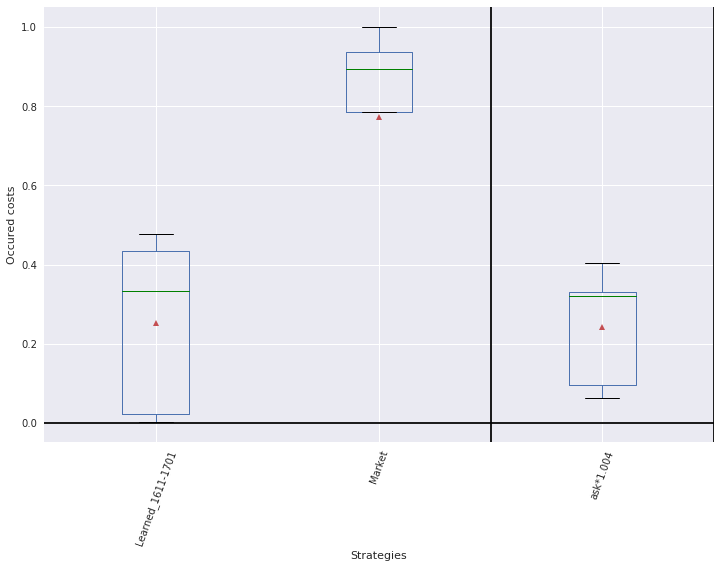

Minimal costs reached by S&L strategy: 'ask*1.004': 0.3604


In [8]:
plot_experiment_results(costs_list, name='Trainset (USDT-BTC)')  #, ylim=(-1.5, 1.5))
mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))